# Quasi-Geostrophic Omega Inversion

Author: Clairisse Reiher (clairisse.reiher@colorado.edu)

Last updated: August 13, 2023

This notebook demonstrates how to perform a quasi-geostrophic (QG) omega inversion (i.e., how to solve for the vertical velocity due to different dynamical processes represented in the QG-$\omega$ equation).

### ERA5 Data
This code is set up to perform the inversion using data from the ECMWF's ERA5 Reanalysis. The data is pulled from the *ERA5 hourly data pressure levels from 1940 to present* product.
- See data on pressure levels [here](https://cds-beta.climate.copernicus.eu/datasets/reanalysis-era5-pressure-levels?tab=overview)
- See data on single levels here [here](https://cds-beta.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=overview)

Clicking "Show API Request Code" at the bottom of either of these pages will provide you the code to use when downloading the file using the CDS API.

### The QG-$\omega$ equation and the Q-vector
The quasi-geostrophic omega equation (called "QG-$\omega$" for short) allows us to diagnose vertical velocity under frictionless, adiabatic conditions. In this notebook, we use the "Q-vector" form of the equation, in which the forcing for vertical motion is written in terms of a vector $\vec{Q}$ whose convergence and divergence results in upward and downward vertical motion, respectively.

The Q-vector form of the QG-$\omega$ equation is:

$$ 
\sigma \nabla^2 \omega + f_0^2 \frac{\partial^2 \omega}{\partial p^2} = -2\nabla \cdot \vec{Q} = (-2\nabla \cdot \vec{Q_n}) + (-2\nabla \cdot \vec{Q_s}) \label{qgomega}\tag{1}
$$

where:
- $\sigma$ = a static stability parameter (more on that later)
- $f_0$ = f-plane approximated Coriolis parameter (i.e., the Coriolis parameter at a single latitude)
- $\omega$ = vertical velocity using pressure (not height) as a vertical coordinate
- $p$ = pressure
- $\vec{Q}$ = the Q-vector
- $\vec{Q}_n$ and $\vec{Q}_s$ = the $\hat{n}$ and $\hat{s}$ components of the Q-vector (more on that below)

The left-hand side of equation ($\ref{qgomega}$) contains the 3D laplacian of $\omega$, while the right-hand side of equation ($\ref{qgomega}$) can be referred to as the forcing for $\omega$.

As hinted in equation ($\ref{qgomega}$), the Q-vector can be split into two different components: $\vec{Q}_n$, which points normal to contours of potential temperature (in the direction of the potential temperature gradient vector $\nabla \theta$), and $\vec{Q}_s$ which points tangent to contours of potential temperature.

1. $\vec{Q}_n$ - diagnoses changes in the magnitude of $\nabla \theta$, and represents forcing for vertical motion due to frontogenesis/frontolysis
2. $\vec{Q}_s$ - diagnoses changes in the direction of $\nabla \theta$; from [Baiman et al. (2022)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2022JD037859): "is frequently associated with the development of a thermal ridge that characterizes the occluded quadrant of a cyclone and is predominantly responsible for ascent in that region"

Let the right-hand side of equation ($\ref{qgomega}$) (the forcing for $\omega$) be referred to as $F$. We can let $F = -2\nabla \cdot \vec{Q}$ and solve for the resulting $\omega$ distribution due to the full Q-vector. However, we can also let $F = -2\nabla \cdot \vec{Q}_n$ or $F = -2\nabla \cdot \vec{Q}_s$ to solve for the resulting $\omega$ distribution solely due to changes in the magnitude of $\nabla \theta$ or changes in the direction of $\nabla \theta$, respectively.


### Solving for $\omega$

To solve for $\omega$ in equation ($\ref{qgomega}$), we first have to convert all derivatives appearing on the right-hand side to expressions that can be numerically solved using finite differencing. Without going into too much explanation, replacing the left-hand side with $F$ and replacing all derivatives with their finite differencing approximations gives:

\begin{align*}
\frac{\sigma}{a^{2} \cos ^{2} \phi} \left( \frac{\omega_{i+1,j,k} - 2\omega_{i,j,k} + \omega_{i-1,j,k}}{(\Delta \lambda)^2} \right)+&\\
\frac{\sigma}{a^{2} \cos \phi} \left( \frac{\cos\phi_{j+1/2}(\omega_{i,j+1,k} - \omega_{i,j,k}) - \cos\phi_{j-1/2}(\omega_{i,j,k} - \omega_{i,j-1,k})}{(\Delta \phi)^2} \right) +&\\
f_0^2\left( \frac{\omega_{i,j,k+1} - 2\omega_{i,j,k} + \omega_{i,j,k-1}}{(\Delta p)^2} \right) &= F\\
\end{align*}

where:
- $i$ = index in the longitudinal (zonal) direction
- $j$ = index in the latitudinal (meridional) direction
- $k$ = index in the vertical direction (references individual pressure levels)
- $a$ = average radius of the Earth
- $\phi$ = latitude
- $\lambda$ = longitude


We want to solve this equation for $\omega_{i,j,k}$, so we should isolate $\omega_{i,j,k}$ on one side of the equation. Below is a rearranged version of the above equation so that $\omega_{i,j,k}$ is only multiplied by a coefficient on the left-hand side:

\begin{align*}
\left ( -\frac{2\sigma}{\cos^2\phi_j} - \frac{\sigma (\Delta \lambda)^2}{(\Delta \phi)^2  \cos\phi_j}\left( \cos\phi_{j+1/2} +  \cos\phi_{j-1/2} \right) - 2\left(\frac{f_0 a \Delta \lambda}{\Delta p}\right)^2 \right) \omega_{i,j,k} =\\
F_{i,j,k} (a \Delta \lambda)^2 - \frac{\sigma}{\cos^2\phi_j}\left( \omega_{i+1,j,k} +  \omega_{i-1,j,k} \right) -  \left( \frac{\sigma (\Delta \lambda)^2 \cos\phi_{j+1/2}}{(\Delta \phi)^2  \cos\phi_j} \right) \omega_{i,j+1,k} \\
- \left( \frac{\sigma (\Delta \lambda)^2 \cos\phi_{j-1/2}}{(\Delta \phi)^2  \cos\phi_j} \right) \omega_{i,j-1,k} - \left(\frac{f_0 a \Delta \lambda}{\Delta p}\right)^2 \left(\omega_{i,j,k+1} +  \omega_{i,j,k-1} \right)\\
\end{align*}

We can represent each of the coefficients that appear before each instance of $\omega$ with $A_1, A_2, ...$ and isolate $\omega_{i,j,k}$:

\begin{align*}
A_1 \omega_{i,j,k} &= F_{i,j,k} (a \Delta \lambda)^2 + A_2\left( \omega_{i+1,j,k} + \omega_{i-1,j,k} \right) + A_3\omega_{i,j+1,k} + A_4\omega_{i,j-1,k} + A_5\left(\omega_{i,j,k+1} + \omega_{i,j,k-1} \right)\\
\omega_{i,j,k} &= \frac{1}{A_1} \left( F_{i,j,k} (a \Delta \lambda)^2 + A_2\left( \omega_{i+1,j,k} + \omega_{i-1,j,k} \right) + A_3\omega_{i,j+1,k} + A_4\omega_{i,j-1,k} + A_5\left(\omega_{i,j,k+1} +  \omega_{i,j,k-1} \right) \right)
\label{qgomega_disc}\tag{2}
\end{align*}

Equation ($\ref{qgomega_disc}$) is the form of the QG-$\omega$ equation that we'll use to solve for $\omega_{i,j,k}$, yielding the $\omega$ distribution that results from the forcing $F$. As mentioned above, we can let $F$ equal one of the three following expressions:
1. $-2\nabla \cdot \vec{Q}$
2. $-2\nabla \cdot \vec{Q}_n$
3. $-2\nabla \cdot \vec{Q}_s$

In [2]:
# Import all modules
import numpy as np
from datetime import datetime
import xarray as xr
import metpy.calc as mpcalc
from metpy.units import units
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import colormaps as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature

**Edit the code cell below** to tell the code some things about the data you'd like to use to perform the inversion, including:
- `time`: date and time of the data
- `latN`,`latS`,`lonW`, `lonE`: the northern, southern, western, and eastern bounds of the horizontal domain, in latitude and longitude
- `level_bottom`, `level_top`: the pressure levels at the bottom and top of the domain, in hPa
- `csdapi_download`: which method to use when loading in the data

The code provides two different ways to open a file containing the data we'll use to perform the inversion.
- Method 1: use `cdsapi_download = True` to download a file containing data from the ERA5 Reanalysis for a given time, domain, and list of pressure levels. Uses the Climate Data Store (CDS) API to do this. The downloaded file is then opened in the code.
- Method 2: use `cdsapi_download = False` to open a file that has already been downloaded, which you must provide the path to.

The bottom pressure level should be representative of the Earth's surface, and the top pressure level should be representative of the tropopause. This is to be physically consistent with the boundary conditions for the solution of $\omega$, which specify that $\omega = 0$ at all boundaries, including the top and bottom pressure levels.

When choosing the latitude/longitude bounds of the horizontal domain for your data, you will probably want to select bounds that are at least 5$^\circ$ outside of the bounds you expect to use for actually plotting $\omega$. If you pick bounds for the data that are too close to the plotting bounds, you might see strange artifacts in the $\omega$ distribution owing to the boundary conditions used when solving for $\omega$. As an example: if you plot a domain bounded by 65$^\circ$N - 15$^\circ$N, 225$^\circ$E - 315$^\circ$E, you might select a domain for you data that is bounded by 70$^\circ$N - 10$^\circ$N, 220$^\circ$E - 320$^\circ$E.

In [3]:
# Choose time, domain, and list of pressure levels
time = '12/23/22 12:00'  # must be in format 'MM/DD/YY HH:00'
latN = 70                # northernmost latitude in domain, must be between 90º and -90º
latS = 10                # southernmost latitude in domain, must be between 90º and -90º
lonW = 220               # westernmost longitude in domain, must be between 0º and 360º
lonE = 320               # easternmost longitude in domain, must be between 0º and 360º

level_bottom  = 1000     # pressure level at bottom of domain, in hPa
level_top     = 100      # pressure level at top of domain, in hPa

# Choose which method to use for opening the data file (set to True or False)
cdsapi_download = False

In [4]:
########## ONLY RUN THIS CELL ONCE ###########

# Obtain datetime object from string containing time
time_dt = datetime.strptime(time,'%m/%d/%y %H:%M')

### Method 1
if cdsapi_download == True:
    
    # Create name for file when it downloads
    filename = 'era5_'+time_dt.strftime('%Y%m%d_%H')+'00.nc'
    
    # Download ERA5 data for entire globe at specified time
    # Only download data at pressure level intervals of 50 hPa
    import cdsapi
    client = cdsapi.Client()
    dataset = "reanalysis-era5-pressure-levels"
    request = {
        'product_type': ['reanalysis'],
        'variable': ['geopotential', 'temperature'],
        'year': [time_dt.strftime('%Y')],
        'month': [time_dt.strftime('%m')],
        'day': [time_dt.strftime('%d')],
        'time': [time_dt.strftime('%H:00')],
        'pressure_level': [format(level,'d') for level in np.arange(level_top,level_bottom+50,50)],
        'data_format': 'netcdf',
        'download_format': 'unarchived'}
    client.retrieve(dataset, request, filename)
    file_path = './'+filename
    
    
### Method 2
else:
    
    # Insert the path to the file, including the name of the file, into the string below
    file_path = './data_omega_inversion/era5_20221223_1200.nc'

    
    
# Load file into code
file = xr.open_dataset(file_path)

To perform the inversion, we only need to **load in two meteorological variables** from ERA5:
1. 3D temperature 
2. 3D geopotential height

ERA5 does not provide geopotential height, but it provides geopotential. All we have to do to convert geopotential to geopotential height is divide by gravitational acceleration.

After loading in these variables, we'll use them to **calculate the Q-vector**, and **split the Q-vector into its $\hat{n}$ and $\hat{s}$ components**. The calculation of the Q-vector uses the [q-vector()](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.q_vector.html) function from the [MetPy Python package](https://unidata.github.io/MetPy/latest/index.html). The split of the Q-vector into its components is performed using:

$$ \vec{Q}_n = \left( \frac{\vec{Q} \cdot \nabla\theta}{|\nabla\theta|} \right) \frac{\nabla\theta}{|\nabla\theta|} $$

$$ \vec{Q}_s = \left( \frac{\vec{Q} \cdot (\hat{k} \times \nabla\theta)}{|\nabla\theta|} \right) \frac{\hat{k} \times \nabla\theta}{|\nabla\theta|} $$

The divergence of $\vec{Q}$, the divergence of $\vec{Q}_n$, and the divergence $\vec{Q}_s$ will be used to calculate three different forcings that will yield three different omega distributions: $\omega_{full}$, $\omega_{Q_n}$, and $\omega_{Q_s}$. Because $\vec{Q} = \vec{Q}_n + \vec{Q}_s$, it is also true that $\omega_{full} = \omega_{Q_n} + \omega_{Q_s}$.

In [5]:
# Load in variables we need and add units
temp_3d_era5 = file['t'].sel(valid_time=time_dt, latitude=slice(latN,latS), longitude=slice(lonW,lonE))
gp_3d_era5   = file['z'].sel(valid_time=time_dt, latitude=slice(latN,latS), longitude=slice(lonW,lonE))
temp_3d_era5 = temp_3d_era5 * units.kelvin
gp_3d_era5   = gp_3d_era5 * (units.meter**2) / (units.second**2)

# Convert geopotential to geopotential height by dividing by gravity
gph_3d_era5 = gp_3d_era5 / (9.81 * units.meter / (units.second**2))
del gp_3d_era5

# Apply Gaussian smoothing in the latitude and longitude dimensions
# "degree" is an integer that adjusts the smoothing (a larger degree means more dramatic smoothing)
degree = 25
temp_3d = mpcalc.smooth_gaussian(temp_3d_era5, n=degree)
gph_3d  = mpcalc.smooth_gaussian(gph_3d_era5, n=degree)

In [6]:
# Set constants we'll need later
Rd = 287.06 * (units.joule) / (units.kilogram * units.kelvin) # gas constant for dry air
cp = 1005 * (units.joule) / (units.kilogram * units.kelvin)   # specific heat at constant pressure
rE = 6.3781E6 * units.meter                                   # radius of the Earth in meters

# Obtain values of latitude, longitude, pressure
# Convert pressure from hectopascals to pascals
press = temp_3d.pressure_level * 100 * units.pascal
lats  = temp_3d.latitude * units.degrees
lons  = temp_3d.longitude * units.degrees

# Create 3D arrays of pressure, lat, and lon
lats_3d, press_3d, lons_3d = np.meshgrid(lats, press, lons)

# Get the difference in pressure between adjacent pressure levels
# This pressure difference should NOT change across the entire 3D grid
dp = np.diff(press)[0] * units.pascal

# Get the difference in latitude and longitude between adjacent values in radians
# These differences also should NOT change across the entire 3D grid
dlon = np.radians(np.abs(np.diff(lons)[0]))
dlat = np.radians(np.abs(np.diff(lats)[0]))

# Create arrays of the x and y distance between adjacent values in the latitude and longitude arrays
dx_3d, dy_3d = mpcalc.lat_lon_grid_deltas(lons_3d, lats_3d)

# Calculate the Coriolis parameter using an f-plane approximation and the average latitude in
# the domain
f_0 = mpcalc.coriolis_parameter(np.mean(lats)).metpy.magnitude

# Use the 3D temperature and 3D pressure to calculate 3D potential temperature
press_ref = 100000 * units.pascal
tpot_3d = temp_3d*((press_ref/press_3d)**(Rd/cp))

In [7]:
# Calculate the 3D geostrophic wind
ugeo_3d, vgeo_3d = mpcalc.geostrophic_wind(gph_3d, dx=dx_3d, dy=dy_3d, latitude=lats_3d)

# Initialize DataArray objects with values of zero: one for the x component of the Q vector (Q_x),
# and one for the y component of the Q vector (Q_y)
Q_x = xr.DataArray(data=np.zeros(np.shape(ugeo_3d)), coords=ugeo_3d.coords, dims=ugeo_3d.dims)
Q_y = xr.DataArray(data=np.zeros(np.shape(ugeo_3d)), coords=ugeo_3d.coords, dims=ugeo_3d.dims)
Q_x = Q_x * (units.meter**2) / units.kilogram / units.second
Q_y = Q_y * (units.meter**2) / units.kilogram / units.second

# Calculate and save the i and j components of the Q vectors one pressure level at a time 
# (the Metpy q_vector function does not work for 3D inputs)
for i in range(0,len(press)):
    Q_x_atpress, Q_y_atpress = mpcalc.q_vector(ugeo_3d[i,:,:], 
                                               vgeo_3d[i,:,:], 
                                               temp_3d[i,:,:], 
                                               pressure=press[i],
                                               dx=dx_3d[i,:,:], dy=dy_3d[i,:,:])
    Q_x[i,:,:] = Q_x_atpress
    Q_y[i,:,:] = Q_y_atpress
    
# Find magnitude of the potential temperature gradient vector: |∇θ|
theta_grad_y, theta_grad_x = mpcalc.gradient(tpot_3d, axes=(1,2), deltas = (dy_3d, dx_3d))
theta_grad_squared = (theta_grad_x**2) + (theta_grad_y**2)

# Calculate components of Q_n in the x and y directions
Q_nx = ((Q_x*(theta_grad_x**2)) + (Q_y*theta_grad_x*theta_grad_y))/theta_grad_squared
Q_ny = ((Q_y*(theta_grad_y**2)) + (Q_x*theta_grad_x*theta_grad_y))/theta_grad_squared

# Calculate components of Q_s in the x and y directions
Q_sx = ((Q_x*(theta_grad_y**2)) - (Q_y*theta_grad_x*theta_grad_y))/theta_grad_squared
Q_sy = ((Q_y*(theta_grad_x**2)) - (Q_x*theta_grad_x*theta_grad_y))/theta_grad_squared

# Calculate -2 * divergence of the full Q vector, Qn, and Qs, which gives the forcing
# on the right hand side of the QG-omega equation
Q_full_div = -2 * mpcalc.divergence(Q_x,  Q_y,  dx=dx_3d, dy=dy_3d, x_dim=-1, y_dim=-2)
Q_n_div    = -2 * mpcalc.divergence(Q_nx, Q_ny, dx=dx_3d, dy=dy_3d, x_dim=-1, y_dim=-2)
Q_s_div    = -2 * mpcalc.divergence(Q_sx, Q_sy, dx=dx_3d, dy=dy_3d, x_dim=-1, y_dim=-2)

Now we need to calculate the static stability parameter $\sigma$ that appears in the QG-$\omega$ equation. We can calculate $\sigma$ as:

$$ \sigma = -\frac{RT_0}{p\theta_0} \frac{\partial \theta_0}{\partial p} $$

where $T_0$ and $\theta_0$ are averaged $T$ and $\theta$ across the horizontal domain at each pressure level. The averages are weighted by the cosine of the latitude.

In [8]:
# Calculate the static stability parameter

# Calculate the average of the temperature and potential temperature across the domain
# weighted by the cosine of the latitude
weights = np.cos(np.radians(temp_3d.latitude))
temp_3d_weighted = temp_3d.weighted(weights)
tpot_3d_weighted = tpot_3d.weighted(weights)
temp_0 = temp_3d_weighted.mean(dim=['latitude','longitude']) #.values * units.kelvin
tpot_0 = tpot_3d_weighted.mean(dim=['latitude','longitude']) #.values * units.kelvin

# Take the derivative of the averaged potential temperature with respect to pressure
stat_stability = mpcalc.first_derivative(tpot_0, delta=dp)

# Calculate the static stability parameter (note: this is a 1D array following the pressure dimension)
sigma = -1 * Rd * temp_0 / press / tpot_0 * stat_stability

# Convert this 1D array to a full 3D array
___, sigma_3d, __ = np.meshgrid(lats, sigma, lons)
sigma_3d = sigma_3d * sigma.metpy.units

We have to **calculate the coefficients** appearing in our discretized form of the QG-$\omega$ equation ($A_1$, $A_2$, etc.). From our previous math at the start of this notebook:

\begin{align*}
A_1 &= -\frac{2\sigma}{\cos^2\phi_j} - \frac{\sigma (\Delta \lambda)^2}{(\Delta \phi)^2  \cos\phi_j}\left( \cos\phi_{j+1/2} +  \cos\phi_{j-1/2} \right) - 2\left(\frac{f_0 a \Delta \lambda}{\Delta p}\right)^2\\
A_2 &= - \frac{\sigma}{\cos^2\phi_j}\\
A_3 &= - \frac{\sigma (\Delta \lambda)^2 \cos\phi_{j+1/2}}{(\Delta \phi)^2  \cos\phi_j}\\
A_4 &= - \frac{\sigma (\Delta \lambda)^2 \cos\phi_{j-1/2}}{(\Delta \phi)^2  \cos\phi_j}\\
A_5 &= - \left(\frac{f_0 a \Delta \lambda}{\Delta p}\right)^2\\
\end{align*}

In [9]:
# Calculate arrays of latitude at indices j - 1/2 and j + 1/2
lats_3d_jminushalf = lats_3d - (dlat/2.0)
lats_3d_jplushalf  = lats_3d + (dlat/2.0)

# Convert all latitude and longitude arrays to radians before proceeding
lats_3d_jminushalf_rad = np.radians(lats_3d_jminushalf)
lats_3d_jplushalf_rad  = np.radians(lats_3d_jplushalf)
lats_3d_rad = np.radians(lats_3d)
lons_3d_rad = np.radians(lons_3d)

# Calculate each of the coefficients, A1 through A5
# To prevent issues later in the code, we'll remove all Metpy units from values included in the calculations here
A_1_term1 = -2 * sigma_3d.m / ((np.cos(lats_3d_rad))**2)
A_1_term2 = -1 * sigma_3d.m * (dlon**2) / (dlat**2) / np.cos(lats_3d_rad) * (np.cos(lats_3d_jplushalf_rad) + np.cos(lats_3d_jminushalf_rad))
A_1_term3 = -2 * ((f_0 * rE.m * dlon/dp.m)**2)
A_1 = A_1_term1 + A_1_term2 + A_1_term3

A_2 = -1 * sigma_3d.m / ((np.cos(lats_3d_rad))**2)
A_3 = -1 * sigma_3d.m * (dlon**2) * np.cos(lats_3d_jplushalf_rad) / (dlat**2) / np.cos(lats_3d_rad)
A_4 = -1 * sigma_3d.m * (dlon**2) * np.cos(lats_3d_jminushalf_rad) / (dlat**2) / np.cos(lats_3d_rad)
A_5 = -1 * ((f_0 * rE.m * dlon/dp.m)**2)

# Calculate the term containing the forcing from Q vectors that gets multiplied by some other stuff 
# for each type of Q-vector 
# Remove all Metpy units like done above
forcing_terms = {}
Qvec_names = ['Q_full', 'Q_n', 'Q_s']
Qvec_div   = [Q_full_div, Q_n_div, Q_s_div]
for i in range(0,len(Qvec_names)):
    forcing_terms[Qvec_names[i]] = Qvec_div[i].metpy.magnitude * ((rE.m * dlon)**2)

We'll now use a technique called **successive over-relaxation (SOR)** to solve Equation (2) for $\omega_{i,j,k}$ for each the three forcings separately. Take a look at the comments in the code cell below to see how it works.

In [10]:
# This dictionary will hold each of the three omega distributions (due to the three different forcings)
omega_solutions = {}

for Qvec_name in Qvec_names:
    
    forcing_term = forcing_terms[Qvec_name]
    
    print('\nNow solving for omega due to',Qvec_name)

    # Parameters used in the SOR routine that we can adjust if needed
    alpha          = 1.0    # Over-relaxation parameter (aka learning rate)
    tolerance      = 1.0    # Tolerance to determine when to stop SOR routine (for example, 1e-1 -> stop when solutions change by less than total of 1 dPa)
    max_iterations = 10000  # Max number of times SOR routine will run

    # Get count of longitude, latitude, and pressure grid points (count of i, j, and k indices)
    numpts_i = len(lons)
    numpts_j = len(lats)
    numpts_k = len(press)

    # Initialize array of zeroes to represent omega values. The lateral bouundary conditions for omega will remain 0,
    # while the zeros in place of the other omega values represent a first "solution" that the SOR routine starts with
    omega = np.zeros(np.shape(forcing_term))

    # Initialize arrays of omega that are offset in either the i, j, or k indices to represent the various
    # omega terms at different indices (all omega terms except for omega_i,j,k)
    omega_iadd1 = omega[1:-1,1:-1,2:]
    omega_isub1 = omega[1:-1,1:-1,0:-2]
    omega_jadd1 = omega[1:-1,2:,1:-1]
    omega_jsub1 = omega[1:-1,0:-2,1:-1]
    omega_kadd1 = omega[2:,1:-1,1:-1]
    omega_ksub1 = omega[0:-2,1:-1,1:-1]

    # Iterate to solve the entire 3D grid of omega. Each time an iteration occurs, omega will be solved
    # at every grid point. The difference between the previous result for omega and the current result for omega
    # is calculated and summed across all grid points. This sum of differences will become very small once the SOR 
    # routine "converges" on a final solution for omega. The routine stops iterating/solving once the sum of differences
    # falls below the specified tolerance threshold or the maximum number of iterations is reached.
    total_diff = 0
    num_iterations = 0
    while num_iterations < max_iterations:

        # Calculate the new solution for omega
        omega_temp = (1/A_1[1:-1,1:-1,1:-1]) * (forcing_term[1:-1,1:-1,1:-1] + (A_2[1:-1,1:-1,1:-1]*(omega_iadd1 + omega_isub1)) 
                                     + (A_3[1:-1,1:-1,1:-1]*omega_jadd1) + (A_4[1:-1,1:-1,1:-1]*omega_jsub1) + (A_5*(omega_kadd1 + omega_ksub1)))

        # Calculate the difference between this solution and last updated values for omega
        diff = omega_temp - omega[1:-1,1:-1,1:-1]

        # Use this difference to nudge the current values for omega closer to a final solution
        omega[1:-1,1:-1,1:-1] = omega[1:-1,1:-1,1:-1] + (alpha * diff)

        # Calculate the sum of the differences across all dimensions
        total_diff = np.sum(np.abs(diff))

        num_iterations = num_iterations + 1

        # If the sum of the differences between the previous solution for omega and the new solution for omega at
        # all the grid points is less than our tolerance value, then we consider the solutions to have converged
        if total_diff < tolerance:
            print('Converged on solution')
            print('Total number of iterations: '+format(num_iterations))
            print('Final sum of differences: '+format(total_diff))
            break #End loop
        else:
            if num_iterations%500 == 0:
                print('Iteration '+format(num_iterations,'04d')+': sum of differences = '+format(total_diff))

        # Reset the sum of the differences before iterating again
        total_diff = 0

    # Save final omega field into DataArray, and store in our dictionary of omega solutions due to different forcings
    omega_da = xr.DataArray(omega, dims = ('pressure','latitude','longitude'), 
                            name = 'omega_'+Qvec_name, 
                            coords = {'pressure':press.values/100,'latitude':lats.values, 'longitude':lons.values})
    omega_da.attrs['units'] = str('pascal / second')
    omega_solutions[Qvec_name] = omega_da


Now solving for omega due to Q_full
Iteration 0500: sum of differences = 228.08821338471014
Iteration 1000: sum of differences = 118.2882299041787
Iteration 1500: sum of differences = 72.82971199015856
Iteration 2000: sum of differences = 47.86412899641532
Iteration 2500: sum of differences = 32.62933336387276
Iteration 3000: sum of differences = 22.766963369820303
Iteration 3500: sum of differences = 16.154828412463672
Iteration 4000: sum of differences = 11.613357612760655
Iteration 4500: sum of differences = 8.43794880972917
Iteration 5000: sum of differences = 6.18799932974356
Iteration 5500: sum of differences = 4.577604579286252
Iteration 6000: sum of differences = 3.4158771369609773
Iteration 6500: sum of differences = 2.5719723262577836
Iteration 7000: sum of differences = 1.9547250662259135
Iteration 7500: sum of differences = 1.500242214546297
Iteration 8000: sum of differences = 1.1634895441171964
Converged on solution
Total number of iterations: 8309
Final sum of differenc

The next code cells **plot the distributions of $\omega$** solved due to $\vec{Q}$, $\vec{Q}_n$, and $\vec{Q}_s$, along with the corresponding Q-vector distributions and the distribution of potential temperature. The code is set up to plot at a pressure level of 700 hPa, but you can change the value of `plotlevel` to pick a different pressure level.

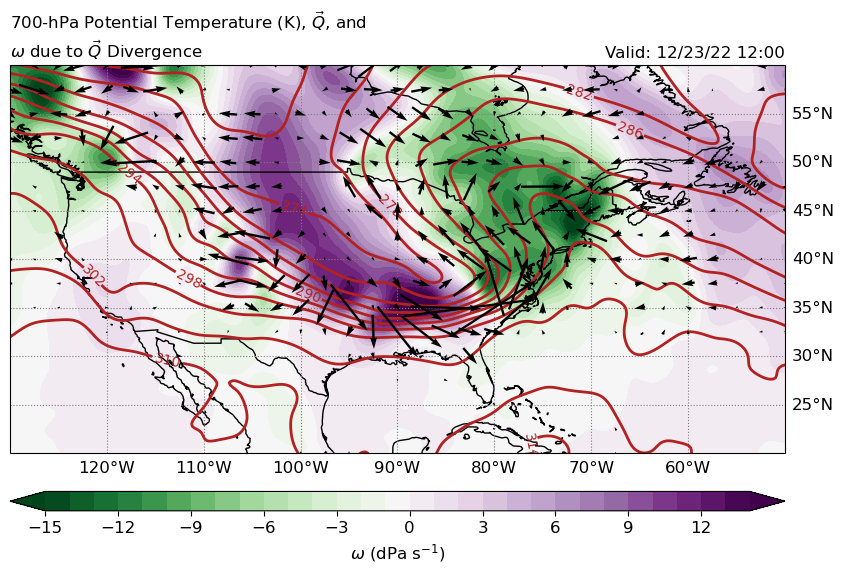

In [11]:
### First figure - omega due to full Q-vector

# Select pressure level to plot at (in hPa)
plotlevel = 700

# Set up projections used for the map and the data
mapcrs  = ccrs.PlateCarree(central_longitude= lonW + ((lonE-lonW)/2))
datacrs = ccrs.PlateCarree()

# Set contouring intervals
clev_tpot  = np.arange(250,400,4)   # in Kelvin
clev_omega = np.arange(-15,15,1)    # in dPa/s (1 dPa/s = 0.1 Pa/s)

# Set figure size
fig_full = plt.figure(figsize=(10,10))

# Create axes and set extent
ax_full = plt.axes(projection = mapcrs)
ax_full.set_extent([230, 310, 20, 60], datacrs)

# Add geopolitical boundaries
ax_full.add_feature(cfeature.COASTLINE)
ax_full.add_feature(cfeature.BORDERS)
#ax_full.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)

#Add gridlines and remove top + left labels
gridlines = ax_full.gridlines(color='gray',ls='dotted',draw_labels=True)
gridlines.top_labels  = False
gridlines.left_labels = False
gridlines.xlabel_style = {'size': 'large'}
gridlines.ylabel_style = {'size': 'large'}

# Add shading of omega; convert from Pa/s to dPa/s
omega_plot = omega_solutions['Q_full'].sel(pressure = plotlevel)
contf = ax_full.contourf(omega_plot.longitude, omega_plot.latitude, 
                         omega_plot*10, 
                         clev_omega,
                         cmap=cm['PRGn_r'], 
                         extend='both', 
                         transform=datacrs)

# Add colorbar for omega shading
cbar = plt.colorbar(contf, orientation='horizontal', pad=0.05, aspect=40)
cbar.set_label(r'$\omega$ (dPa s$^{-1}$)', size='large')
cbar.ax.tick_params(labelsize='large')

# Add contours of potential temperature
tpot_plot = tpot_3d.sel(pressure_level=plotlevel)
cont = ax_full.contour(tpot_plot.longitude, tpot_plot.latitude, 
                       tpot_plot, clev_tpot, 
                       colors='firebrick',
                       linewidths=2.0, transform=datacrs)
plt.clabel(cont, fontsize=10, inline=1, inline_spacing=3, rightside_up=True, use_clabeltext=True)

# Add Q-vectors
# Filter out all Q-vectors below a certain magnitude and only plot vectors above that value in
# magnitude
quiv_slice = slice(None, None, 10)
Q_x_plot = Q_x.sel(pressure_level=plotlevel).isel(latitude=quiv_slice, longitude=quiv_slice)
Q_y_plot = Q_y.sel(pressure_level=plotlevel).isel(latitude=quiv_slice, longitude=quiv_slice)
max_magnitude = 5e-13 * (units.meter**2) / units.kilogram / units.second
Q_magnitude = ((Q_x_plot**2) + (Q_y_plot**2))**(1/2)
ax_full.quiver(Q_x_plot.longitude.values, Q_x_plot.latitude.values,
          Q_x_plot.where(Q_magnitude > max_magnitude).values,
          Q_y_plot.where(Q_magnitude > max_magnitude).values,
          pivot='mid', color='black',
          scale=2e-11, scale_units='inches',
          width=0.003,
          transform=datacrs,
          zorder=5)

# Add title
plt.title(format(plotlevel)+r'-hPa Potential Temperature (K), $\vec{Q}$, and' + '\n'+ r'$\omega$ due to $\vec{Q}$ Divergence',loc='left')
plt.title('Valid: '+time, loc='right')

# Save figure and show
plt.savefig('omega_Q_full.pdf')
plt.show()

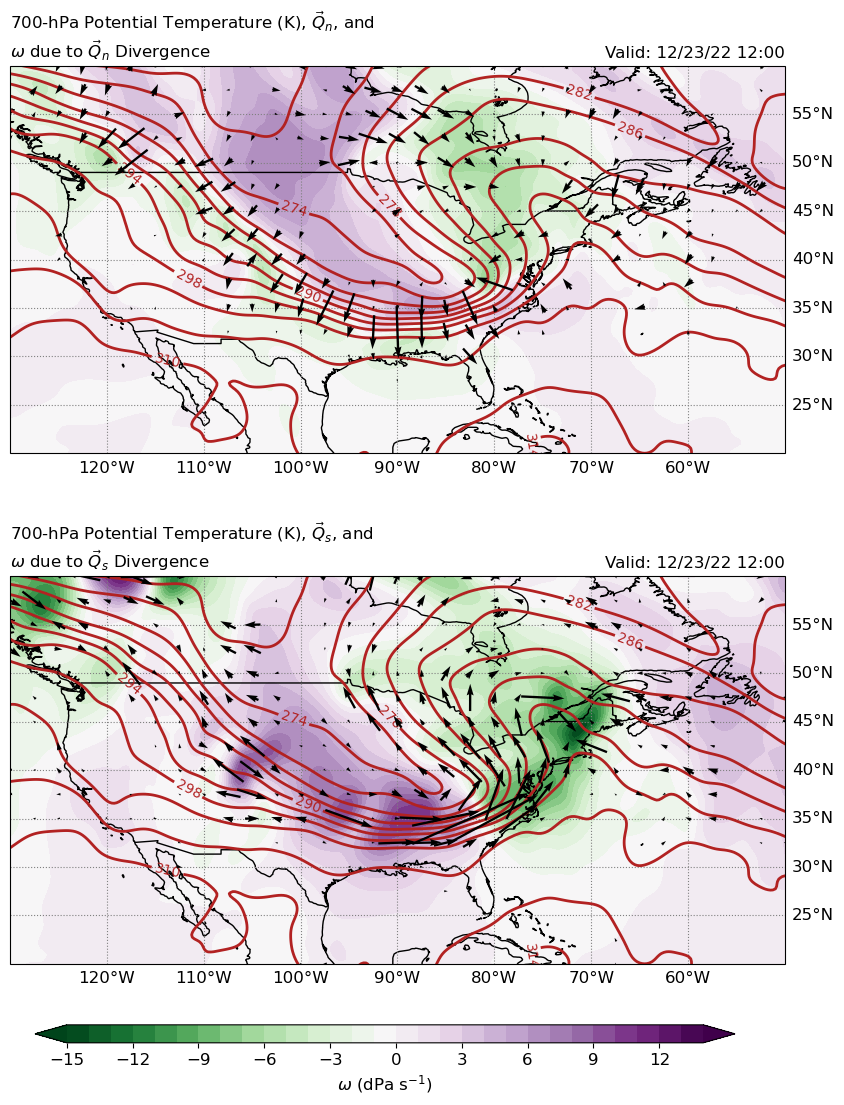

In [12]:
### Second figure - omega due to Q_n and Q_s

fig_ns = plt.figure(figsize=(10,12))

# Make two sets of axes - one for each component of Q
ax_n = plt.subplot(211, projection=mapcrs)
ax_s = plt.subplot(212, projection=mapcrs)

# Set different contouring intervals for omega
clev_omega = np.arange(-15,15,1)    # in dPa/s (1 dPa/s = 0.1 Pa/s)

for ax in [ax_n, ax_s]:
    
    # Set axes extent
    ax.set_extent([230, 310, 20, 60], datacrs)
    
    # Add geopolitical boundaries
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    #ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)

    #Add gridlines and remove top + left labels
    gridlines = ax.gridlines(color='gray',ls='dotted',draw_labels=True)
    gridlines.top_labels  = False
    gridlines.left_labels = False
    gridlines.xlabel_style = {'size': 'large'}
    gridlines.ylabel_style = {'size': 'large'}
    
    # Add shading of omega; convert from Pa/s to dPa/s
    if ax == ax_n:
        omega_plot = omega_solutions['Q_n'].sel(pressure = plotlevel)
    else:
        omega_plot = omega_solutions['Q_s'].sel(pressure = plotlevel)
    contf = ax.contourf(omega_plot.longitude, omega_plot.latitude, 
                             omega_plot*10, 
                             clev_omega,
                             cmap=cm['PRGn_r'], 
                             extend='both', 
                             transform=datacrs)
    
    # Add contours of potential temperature
    cont = ax.contour(tpot_plot.longitude, tpot_plot.latitude, 
                      tpot_plot, clev_tpot, 
                      colors='firebrick',
                      linewidths=2.0, transform=datacrs)
    plt.clabel(cont, fontsize=10, inline=1, inline_spacing=3, rightside_up=True, use_clabeltext=True)
    
    # Add Q-vectors
    # Filter out all Q-vectors below a certain magnitude and only plot vectors above that value in
    # magnitude
    if ax == ax_n:
        Q_x_plot = Q_nx.sel(pressure_level=plotlevel).isel(latitude=quiv_slice, longitude=quiv_slice)
        Q_y_plot = Q_ny.sel(pressure_level=plotlevel).isel(latitude=quiv_slice, longitude=quiv_slice)
    else:
        Q_x_plot = Q_sx.sel(pressure_level=plotlevel).isel(latitude=quiv_slice, longitude=quiv_slice)
        Q_y_plot = Q_sy.sel(pressure_level=plotlevel).isel(latitude=quiv_slice, longitude=quiv_slice)
    max_magnitude = 5e-13 * (units.meter**2) / units.kilogram / units.second
    Q_magnitude = ((Q_x_plot**2) + (Q_y_plot**2))**(1/2)
    ax.quiver(Q_x_plot.longitude.values, Q_x_plot.latitude.values,
              Q_x_plot.where(Q_magnitude > max_magnitude).values,
              Q_y_plot.where(Q_magnitude > max_magnitude).values,
              pivot='mid', color='black',
              scale=2e-11, scale_units='inches',
              width=0.003,
              transform=datacrs,
              zorder=5)
    
    # Add title
    if ax == ax_n:
        ax.set_title(format(plotlevel)+r'-hPa Potential Temperature (K), $\vec{Q}_n$, and' + '\n'+ r'$\omega$ due to $\vec{Q}_n$ Divergence',loc='left')
    else:
        ax.set_title(format(plotlevel)+r'-hPa Potential Temperature (K), $\vec{Q}_s$, and' + '\n'+ r'$\omega$ due to $\vec{Q}_s$ Divergence',loc='left')
    ax.set_title('Valid: '+time, loc='right')

    
    
    
# Add colorbar for omega shading
fig_ns.subplots_adjust(bottom=0.10)
cbar_ax = fig_ns.add_axes([0.15, 0.05, 0.7, 0.015]) #[left, bottom, width, height]
cbar_ax.tick_params(labelsize='large')
cbar = fig_ns.colorbar(contf, cax=cbar_ax, orientation='horizontal')
cbar.set_label(r'$\omega$ (dPa s$^{-1}$)',fontsize='large')

# Save figure and show
plt.savefig('omega_Q_ns.pdf')
plt.show()